In [40]:
import sys 
import os 
from os import path


RESULTS_DIR = '../experiments/results'
GRAPHICS_DIR = '../experiments/results/graphics'

####
# Tenemos que hacer esto por como estan definidos los packages del tp tlengrep
# Si no se ejecuta desde telengrep rompe la ejecucion.
# Lo que hacemos es correr la notebook seteando el "working directory" de python
# como si corriera desde /tlengrep
###
def hack_path_enviroment():
    sys.path.insert(0, "..")
    #os.getcwd()
    os.chdir('../tlengrep/')
    #os.getcwd()


def init_folders():
    if path.exists(f'{RESULTS_DIR}') == False:
        os.mkdir(f'{RESULTS_DIR}')

    if path.exists(f'{GRAPHICS_DIR}') == False:
        os.mkdir(f'{GRAPHICS_DIR}')



In [41]:
os.getcwd()


'/home/nacho/PARA/1. Projects/Q3-Q4/tlen 2c2023/tps/2023-2c-tp-tomas-martin-ignacio-3/tlengrep'

In [42]:
hack_path_enviroment()

init_folders()


In [2]:
import tlengrep.regex as regex

l = regex.Lambda()
l.naive_match('a')

False

In [3]:
TOTAL_INSTANCES = 10
SIZE_STEP = 100
instances = ["ab" * (i*SIZE_STEP) for i in range(1, TOTAL_INSTANCES + 1)]


# instances_dict = {
#     'inst_1': {
#         'name': 'inst_1',
#         ''
#     }
# }

In [4]:
def generate_regular_expression_1():
    return regex.Star(regex.Concat(regex.Char('a'), regex.Char('b')))

In [5]:
reg_ex_dict = {
    're_1': {
        'name': 're_1',
        'regex': generate_regular_expression_1(),
        'regex_str': '(ab)*'}
}
    



In [59]:
import string 


# Genera una expresión regular donde una cadena de exto es recorrida k veces hasta el ultimo caracter
# Para esto seleccionamos k caracteres {c1,...ck} y obtenemos las clausuras de kleene {c1*, ..., ck*}.
# Realizamos la concatenación en una expresión regular R1 = c1*c2*...ck*
# Luego tomamos k caracteres distintos {d1,...dk} a los que no les realizamos la clasura y construimos la expresión.
# regular R = (R1 d1 | R1 d2 | R1 d3 | ... | R1 dk)
# para esto hacemos una "suma" de distintas clausuras de kleene para cada caracter 
# Ahora si construimos un string como "R1 dk" la expresión regular debera recorrer 
# cada caso fallando unicamente en el último caracter y
def generate_regulat_expression_2(size=3):
    assert(size*2 <= 52)
    all_letters = list(string.ascii_letters)
    #print(len(all_letters))
    result_alphabet = []

    ## Primero generamos a*, b*, ... hasta size
    closures = []
    for idx in range (0, size):
        letter = all_letters[idx]
        re = regex.Star(regex.Char(letter))
        closures.append(re)
        result_alphabet.append(letter)

    ## Nos con los siguientes k characteres
    sub_regexes = []
    for i in range(0, size):
        idx = (size+i)
        letter = all_letters[idx]
        re = regex.Concat(closures[i], regex.Char(letter))
        sub_regexes.append(re)
        result_alphabet.append(letter)

    ## Ahora generamos la suma de todos los sub_regexes para
    ## construir R = (R1 d1 | ... | R1 dk)
    final_regex = None
    for sub_re in sub_regexes:
        if final_regex is None:
            final_regex = sub_re

        else:
            final_regex = regex.Union(final_regex, sub_re)


    return result_alphabet, final_regex




generate_regulat_expression_2()

(['a', 'b', 'c', 'd', 'e', 'f'], <tlengrep.regex.Union at 0x7f3e80e93a00>)

In [92]:
import random 

reg_ex_exp2_dict = {}

EXP2_INSTANCE_SIZES = [5,10,15,20,25]

for i in EXP2_INSTANCE_SIZES:
    re_dict = {}

    alph, re = generate_regulat_expression_2(size=i)
    re_dict['name'] = f're_exp2_{i}'
    re_dict['alph'] = alph 
    re_dict['re'] = re 
    reg_ex_exp2_dict[re_dict['name']] = re_dict



In [93]:
reg_ex_exp2_dict.keys()

dict_keys(['re_exp2_5', 're_exp2_10', 're_exp2_15', 're_exp2_20', 're_exp2_25'])

In [94]:
exp2_instances_dict = {}

def generate_instances_for_re_2(alphabet, total_instances=10, size_step=100):
    usable_alph = alphabet.copy()
    last_character = usable_alph.pop()
    instances = [  ''.join(random.choices(usable_alph, k=(i*size_step)) + [last_character] ) for i in range(1, total_instances + 1)]
    return instances


for i in EXP2_INSTANCE_SIZES:
    inst_dict = {}
    inst_dict['name'] = f'exp2_inst_{i}'
    alph = reg_ex_exp2_dict[f're_exp2_{i}']['alph']
    inst_dict['instances'] = generate_instances_for_re_2(alph)
    exp2_instances_dict[inst_dict['name']] = inst_dict
    
    



In [95]:
exp2_instances_dict.keys()

dict_keys(['exp2_inst_5', 'exp2_inst_10', 'exp2_inst_15', 'exp2_inst_20', 'exp2_inst_25'])

['bokfbbdsefcnihlkosskqikpfpkilakhhfsjcrnllmlpnlacpjngnjsgdjrsffsaronrfihrsmlbehnlhlieosgiohrdcnigmhkqt',
 'lednoraenkmqopgknahjnsgiholpslmndmccgplpjoejkabqgjmomslbakqbllgsobrdaffsmahlqiahfpoinasnareeoghqjdaaesabmkroppqmamijgcgroqnqrnnhicmnbmbqmidkardleoaplfjfrrjapkffraocjdbahgnasnimbihocfklpeaeijjeboofbhmet',
 'iidogkkrbnimmknbdahcjambrsdrojapdcmhjsrbgminaspreaaaekqmjojlgipikqjerifdccijsrncfbnogoopeaicsoihijhpdsngbpdccnopnejqlknpqrnnmigghldkserpplsbfjcsgeirmakbnldbmhaqprknjjqanepshppeplboanghenmbpeqaqemnibipgjsbogagcmdngnfceprgsprpnoraiarsfkngmrjdranlqjssljkprpkeocmcqonjgreqmrmdebpmisspsdpelkaqaeemloreajdnt',
 'ddbqmpqdcscgdspjqmoijqnfpajgqgcljsfqsdeolbiobqprreqifqoaeidfodqfmkkoiqibiiogirckndpdfnbeasbeiqjghemiekcimlarfrbebsqhhjqjphqnbopsdbsicdafoqipfbbnlbsnmfkckambpkmacdkboqallpsosdmnmiiinshbfkdhfajkikpjsolhaphkcfjqjgcipicmcrkoceisjhqbebdbedeehfermcfdqrjbhigskokijisldkphrfrnehisljobkhirehadsbaamorhkafqfjjsoarjerhcqkamidkphfighplkprslibdpcbcohgggbrfrcsariabgomqqoeajhcddnqrrosmmfjranlsd

In [10]:
import timeit as ti 


def time_regular_expression(reg_exp_dict, instances, verbose=1):

    results = {}
    results['instance'] = instances 
    time_results = []
    results[f'{reg_exp_dict["name"]} - avg time (ms)'] = time_results
    naive_time_results = []
    results[f'{reg_exp_dict["name"]} - naive - avg time (ms)'] = naive_time_results

    reg_exp = reg_exp_dict['regex']
    EXPERIMENT_RUNS = 100 
    if verbose >= 1:
        print(f'Timing regular expression for {len(instances)} instances with {EXPERIMENT_RUNS} experiment runs')

    for idx, instance in enumerate(instances):
        if verbose >= 2:
            print(f'Running experiment {idx} ...')
        
        ## Calculate regular expression time 
        time = ti.timeit(lambda: reg_exp.match(instance), number=EXPERIMENT_RUNS)
        time = (time / EXPERIMENT_RUNS) * 1000
        time_results.append(time)

        if verbose >= 2:
            print(f'Regular expression average time {time}')

        ## Calculate naive regular expression time 
        time = ti.timeit(lambda: reg_exp.naive_match(instance), number=EXPERIMENT_RUNS)
        time = (time / EXPERIMENT_RUNS) * 1000
        naive_time_results.append(time)

        if verbose >= 2:
            print(f'Regular expression naive implementation average time {time}')
    

    return results

In [11]:
results = time_regular_expression(reg_ex_dict['re_1'], instances, verbose=2)

Timing regular expression for 10 instances with 100 experiment runs
Running experiment 0 ...
Regular expression average time 0.2990778791718185
Regular expression naive implementation average time 2.365490570664406
Running experiment 1 ...
Regular expression average time 0.17408555140718818
Regular expression naive implementation average time 8.528881389647722
Running experiment 2 ...
Regular expression average time 0.175117920152843
Regular expression naive implementation average time 19.279123679734766
Running experiment 3 ...
Regular expression average time 0.3251389996148646
Regular expression naive implementation average time 32.94780891155824
Running experiment 4 ...
Regular expression average time 0.2031012694351375
Regular expression naive implementation average time 53.94714053021744
Running experiment 5 ...
Regular expression average time 0.3596765990369022
Regular expression naive implementation average time 86.30741650005803
Running experiment 6 ...
Regular expression avera

In [25]:
import pandas as pd 

df = pd.DataFrame(results)
df['instance size'] = df['instance'].apply(lambda x: len(x))
df = df.drop(['instance'], axis=1)
df = df.set_index('instance size')
df

,re_1 - avg time (ms),re_1 - naive - avg time (ms)
instance size,,
200,0.299078,2.365491
400,0.174086,8.528881
600,0.175118,19.279124
800,0.325139,32.947809
1000,0.203101,53.947141
1200,0.359677,86.307417
1400,0.238740,110.221693
1600,0.301268,137.351676
1800,0.295627,176.426960


['re_1 - avg time (ms)', 're_1 - naive - avg time (ms)']


<Axes: xlabel='instance size'>

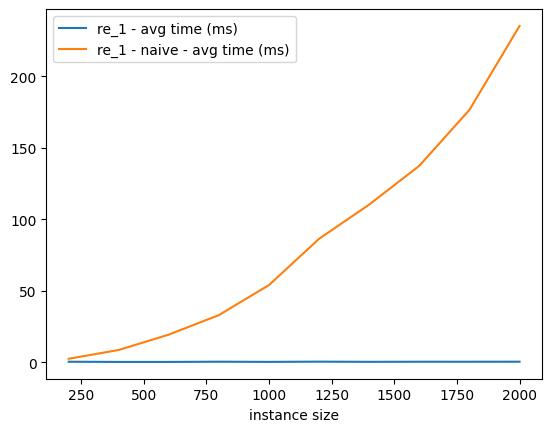

In [13]:
time_cols = []
for col in df.columns:
    if 'avg time' in col:
        time_cols.append(col)

print(time_cols)
df.plot.line(x='instance size', y=time_cols)

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

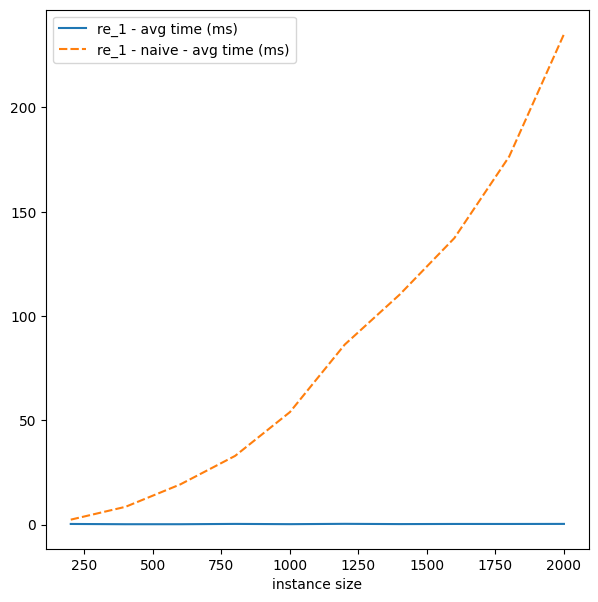

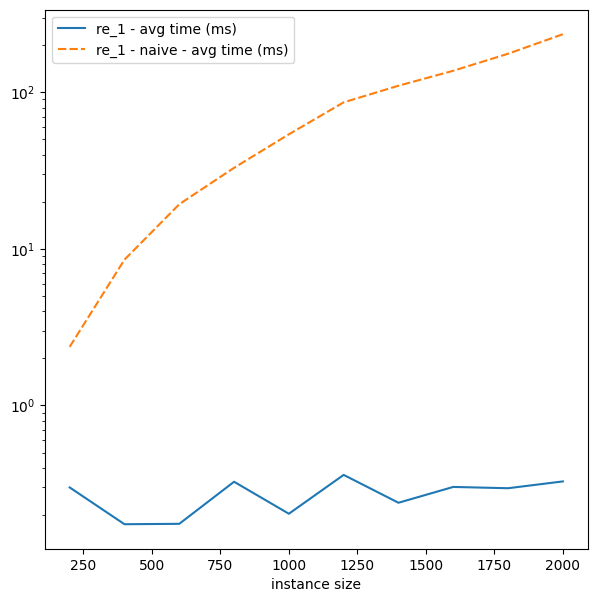

In [43]:
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
sns.lineplot(data=df[time_cols], ax=axes)
plt.savefig(f'{GRAPHICS_DIR}/re_1_times.svg')

fig, axes = plt.subplots(1, 1, figsize=(7, 7))
sns.lineplot(data=df[time_cols], ax=axes)
axes.set_yscale('log')
plt.savefig(f'{GRAPHICS_DIR}/re_1_log_times.svg')



### Experiments 2

In [ ]:
import timeit as ti 


exp2_results_dict = {}
for i in EXP2_INSTANCE_SIZES:
    reg_exp_dict = reg_ex_exp2_dict[f're_exp2_{i}']
    instances_dict = exp2_instances_dict[f'exp2_inst_{i}']

    for inst in instances:
        time_regular_expression(reg_ex_dict, instances_dict['instances'], verbose=2)
        